In [1]:
import numpy as np           
from vizdoom import *        
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import time
import skimage

In [2]:
game = DoomGame()  # must be global

In [3]:
def make_env():
    global game
    game.load_config("/Users/tommasobiancalani/github/ViZDoom/scenarios/basic.cfg")
    game.set_doom_scenario_path("/Users/tommasobiancalani/github/ViZDoom/scenarios/basic.wad")
    game.init()
    # Possible actions
    left = [1, 0, 0]
    right = [0, 1, 0]
    shoot = [0, 0, 1]
    actions = [left, right, shoot]
    return actions
actions = make_env()

In [4]:
def test_environment(actions):
    """
        Play an episode by randomly choosing actions.
    """
    global game
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        action = random.choice(actions)
        reward = game.make_action(action)
    print "Result:", game.get_total_reward()
    game.close()
# test_environment(actions)

In [5]:
def preprocess_frame(img): 
    """
        From RGB screen,greyscale, crop ceiling and bar, 
        resize it to 84x84, standardize pxs.
    """
    img = np.transpose(img, (1, 2, 0))
    img_grey = skimage.color.rgb2grey(img)
    frame = img_grey
#     plt.imshow(img_grey);
    frame = frame[50:200, :]
    frame /= 255
#     plt.imshow(frame);
    frame2 = skimage.transform.resize(frame, [84, 84])
#     plt.imshow(frame2);
    return frame2

/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/tommasobiancalani/anaconda3/envs/py27-dqdoom/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


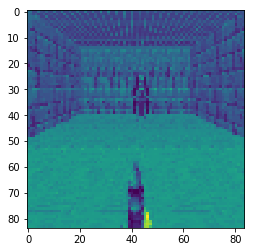

In [6]:
game.new_episode()
state = game.get_state()
img = state.screen_buffer
frame = preprocess_frame(img)
plt.imshow(frame);

In [11]:
from collections import deque  # high-performance list

In [16]:
stacked_frames  =  deque(
    [np.zeros((84,84), dtype=np.int) for i in range(4)], 
    maxlen=4
) 

In [29]:
def stack_frames(is_new_episode):
    global stacked_frame
    global game
    frame = preprocess_frame(state)
    if game.is_new_episode():        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
    else:
        stacked_frames.append(frame)
    return stacked_frames

In [ ]:
class DoomNet:
    def __init__(self, learning_rate):
        self.alpha = learning_rate

In [ ]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, 3], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            BatchNormalization
            ELU
            """
            # Input is 84x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')
            
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            ## --> [20, 20, 32]
            
            
            """
            Second convnet:
            CNN
            BatchNormalization
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
        
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            ## --> [9, 9, 64]
            
            
            """
            Third convnet:
            CNN
            BatchNormalization
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
        
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
            ## --> [3, 3, 128]
            
            
            self.flatten = tf.layers.flatten(self.conv3_out)
            ## --> [1152]
            
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = 3, 
                                        activation=None)

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [ ]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        with tf.variable_scope(name):
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 84, 84, 4]
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions_ = tf.placeholder(tf.float32, [None, 3], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            BatchNormalization
            ELU
            """
            # Input is 84x84x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides = [4,4],
                                         padding = "VALID",
                                          kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv1")
            
            self.conv1_batchnorm = tf.layers.batch_normalization(self.conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')
            
            self.conv1_out = tf.nn.elu(self.conv1_batchnorm, name="conv1_out")
            ## --> [20, 20, 32]
            
            
            """
            Second convnet:
            CNN
            BatchNormalization
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv2")
        
            self.conv2_batchnorm = tf.layers.batch_normalization(self.conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

            self.conv2_out = tf.nn.elu(self.conv2_batchnorm, name="conv2_out")
            ## --> [9, 9, 64]
            
            
            """
            Third convnet:
            CNN
            BatchNormalization
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                 name = "conv3")
        
            self.conv3_batchnorm = tf.layers.batch_normalization(self.conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm3')

            self.conv3_out = tf.nn.elu(self.conv3_batchnorm, name="conv3_out")
            ## --> [3, 3, 128]
            
            
            self.flatten = tf.layers.flatten(self.conv3_out)
            ## --> [1152]
            
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="fc1")
            
            
            self.output = tf.layers.dense(inputs = self.fc, 
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                          units = 3, 
                                        activation=None)

  
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            
            # The loss is the difference between our predicted Q_values and the Q_target
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)